## Building a Self-Aware Classifier Using “IDK” Labels

As a bonus, in this notebook we extend an MNIST digit classifier originally used to evaluate the quality of images generated by the UNet-DDPM classifier-free guidance model from the NVIDIA [Generative AI with Diffusion Models](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+C-FX-08+V1) course assessment.

The classifier is modified to become more self-aware by introducing an “IDK” (I Don’t Know) prediction category. Specifically, when the model’s confidence for a predicted MNIST digit falls below a predefined threshold, the prediction is labeled as IDK rather than forcing a potentially unreliable class assignment. Such uncertain predictions can then be deferred to a human expert for validation or used to analyze the data's aleatoric uncertainty.

In this notebook, we first explore how to select an optimal confidence threshold. We then visually inspect the resulting predictions using the FiftyOne app. Finally, the test set—along with its predictions and associated metadata—is exported as a FiftyOne dataset, which serves as a structured evaluation resource for further qualitative and quantitative analysis of the model’s performance.

In the following cell, we import modules and functions from our `src` package, set random seeds for reproducibility, and define the parameters and file paths used throughout the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import wandb
import random

# On a multi-GPU system, this hides all GPUs except the first 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Custom modules
from handsoncv.models import MnistClassifier, UNet
from handsoncv.training import train_diffusion
from handsoncv.metrics import calculate_idk_metrics, find_optimal_threshold
from handsoncv.utils import (
    DDPM,
    set_seed, 
    _test_mnist_classifier
)
from handsoncv.visualization import (
    plot_bonus_tsk_confidence_distribution, 
    plot_bonus_tsk_acc_coverage_curve
)

# Hardware & Paths
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Folders we frequently use across the experiments' notebooks
ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-3")
ROOT_DATA = os.path.join(ROOT_PATH, "data")
SAMPLE_DIR = f"{ROOT_DATA}/05_mnist_images"
CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Numpy and Torch Reproducibility
SEED=42
set_seed(42)

# Base Configuration Parameters
BATCH_SIZE_CLASSIFIER = 64
BATCH_SIZE_DDPM = 128
IMG_SIZE = 28 # required for UNet/DDPM model 

cuda
Seeds set to 42 for reproducibility.


### Data & Model Loading 

In this section, we load the MNIST classifier checkpoint, which is available in the 'checkpoints' folder of this assignment, together with the diffusion models that were trained in notebook '05_a_*.ipynb' and which form part of the assessment environment of notebook '06_*.ipynb' in the Nvidia Lab course [Generative AI with Diffusion Models](https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+C-FX-08+V1).

The classifier consists of two convolutional layers with max pooling and dropout, followed by two fully connected (linear) layers that output 10 log-probabilities per sample, corresponding to the 10 MNIST digit classes. 

In [2]:
model = MnistClassifier().to(DEVICE)
model.load_state_dict(torch.load(f"{CHECKPOINTS_DIR}/mnist_cnn.pt"))
model

MnistClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

The MNIST test split is loaded using torchvision and transformed into tensors. Pixel values are normalized using the dataset’s standard mean and standard deviation, matching the preprocessing used during training. The dataset is loaded without shuffling to preserve a consistent sample order during evaluation.

To ensure reproducibility, a `torch.Generator` object is created and seeded with a fixed random seed, which is then passed to the DataLoader. Finally, a PyTorch `DataLoader` is created to efficiently batch and load the data during inference.

In [3]:
# Create a Generator object to pass to the dataLoaders
g = torch.Generator()
g.manual_seed(SEED)

# Define common train/valid/test dataloaders kwargs
train_kwargs = {'num_workers': 2, 'pin_memory': True, 'shuffle': True, 'drop_last': True}
test_kwargs = {'num_workers': 2, 'pin_memory': True, 'shuffle': False}

# Base transforms used for UNet/DDPM Model
transform_ddpm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Base transforms used for Mnist Classifier
transform_classifier = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Download MNIST dataset into `../data/` folder and instantiate it via `torchvision.datasets` for DDPM Training
train_dataset_ddpm = datasets.MNIST(ROOT_DATA, train=True, download=True, transform=transform_ddpm)

# We define a split of the training data to extract a small portion to validate on while training the UNet/DDPM Model
dataset_size = len(train_dataset_ddpm)
indices = list(range(dataset_size))
split = int(0.95 * dataset_size)

# Shuffle indices once
random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]

# Create train/validation subsets for DDPM
train_dataset_ddpm_split = Subset(train_dataset_ddpm, train_indices)
val_dataset_ddpm_split   = Subset(train_dataset_ddpm, val_indices)

# DDPM DataLoaders
train_loader_ddpm = DataLoader(train_dataset_ddpm, batch_size=BATCH_SIZE_DDPM, **train_kwargs, generator=g)
val_loader_ddpm = DataLoader(val_dataset_ddpm_split, batch_size=BATCH_SIZE_DDPM, **test_kwargs, generator=g)

# Prepare dataset test split; we will use only the test set to evaluate the pretrained Mnist Classifier
test_dataset_classifier = datasets.MNIST(ROOT_DATA, train=False, transform=transform_classifier, download=True)
test_loader_classifier = DataLoader(test_dataset_classifier, batch_size=BATCH_SIZE_CLASSIFIER, **test_kwargs, generator=g)

print(f"DDPM train samples:         {len(train_loader_ddpm.dataset)}")
print(f"DDPM val samples:           {len(val_loader_ddpm.dataset)}")
print(f"Classifier test samples:    {len(test_loader_classifier.dataset)}")

DDPM train samples:         60000
DDPM val samples:           3000
Classifier test samples:    10000


We first evaluate the model’s accuracy on the full MNIST test set to establish a baseline, which will serve as a reference point for assessing the impact of introducing “IDK” predictions during inference.

In [4]:
_test_mnist_classifier(model, DEVICE, test_loader_classifier)


Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99.17%)



In [5]:
# Training Configuration 
EPOCHS = 50
LEARNING_RATE = 1e-3
SUBSET_SIZE = len(train_dataset_ddpm)
N_CLASSES = 10

# Initialize Model & DDPM recommended hyperparameters 
T = 300
IMG_CH = 1
BETAS = torch.linspace(0.0001, 0.02, T).to(DEVICE)

# Set Seed again for Ensuring Same Model Initialization at Every Run
set_seed(SEED)

ddpm = DDPM(BETAS, DEVICE)
model = UNet(
    T, 
    IMG_CH, 
    IMG_SIZE, 
    down_chs=(64, 64, 128), 
    t_embed_dim=8, 
    c_embed_dim=N_CLASSES
).to(DEVICE)
print("Num params: ", sum(p.numel() for p in model.parameters()))

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    patience=15, # We wait 15 epochs before cutting LR
    factor=0.5,   # We don'tcut it so aggressively
    min_lr=5e-5 # We stop the LR from dropping below 5e-5
)
BOTTLE_EMB_CHANNELS = model.down2.model[-2].model[0].out_channels

# Initialize W&B Run
run = wandb.init(
    project="diffusion-model-assessment-v2", 
    name="ddpm_unet_mnist_training",
    config={
        "architecture": "ddpm_unet",
        "strategy": "generative_modeling_without_ema_without_selfatt_without_aug",
        "downsample_mode": "maxpool",
        "embedding_size": BOTTLE_EMB_CHANNELS,
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE_DDPM,
        "epochs": EPOCHS,
        "optimizer_type": "Adam",
        "subset_size": SUBSET_SIZE,
        "seed": SEED,
    }
)

# Execute Training
train_diffusion(
    model=model,
    ddpm=ddpm,
    train_loader=train_loader_ddpm,
    val_loader=train_loader_ddpm,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=DEVICE,
    drop_prob=0.1,
    save_dir=CHECKPOINTS_DIR,
    sample_save_dir=SAMPLE_DIR,
    clip_model=None,   
    clip_preprocess=None,  
    cond_list=list(range(10)),  
    scheduler=scheduler
)

wandb.finish()

Seeds set to 42 for reproducibility.
Num params:  2115841


wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 0: Train Loss: 0.0726 | Val Loss: 0.0471
Saved samples to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/data/05_mnist_images/sample_ep00.png
Epoch 0: Val Loss: 0.0471
Saved and logged samples for epoch 0
--- Saved new best Val model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/checkpoints ---
Epoch 1: Train Loss: 0.0458 | Val Loss: 0.0425
--- Saved new best Val model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/checkpoints ---
Epoch 2: Train Loss: 0.0434 | Val Loss: 0.0421
--- Saved new best Val model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/checkpoints ---
Epoch 3: Train Loss: 0.0418 | Val Loss: 0.0407
--- Saved new best Val model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/checkpoints ---
Epoch 4: Train Loss: 0.0411 | Val Loss: 0.0409
Epoch 5: Train Loss: 0.0404 | Val Loss: 0.0401
Saved samples to /home/vaness

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_time_sec,▆▁▁▁▅▁▂▁▆▁▁▁▅▂▁▁▅▁▂▂▆▁▁▃█▁▁▃▆▁▁▃▆▁▁▄▆▁▁▆
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
peak_gpu_mem_mb,▁███████████████████████████████████████
train_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch,49
epoch_time_sec,22.48345
learning_rate,0.001
peak_gpu_mem_mb,1113.79639
train_loss,0.03627


In [8]:
# Load UNet/DDPM trained in previous cell
model = UNet(300, 1, IMG_SIZE, down_chs=(64, 64, 128), c_embed_dim=10).to(DEVICE)
model.load_state_dict(torch.load(f"{CHECKPOINTS_DIR}/ddpm_unet_mnist_best_model.pt"))

ddpm = DDPM(torch.linspace(0.0001, 0.02, 300).to(DEVICE), DEVICE)

### Part 1

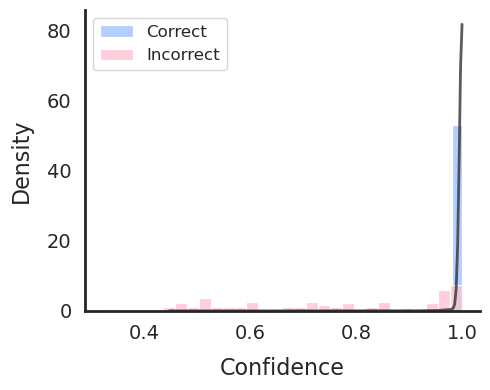

In [5]:
# Usage:
correct_scores, incorrect_scores = plot_bonus_tsk_confidence_distribution(model, test_loader, DEVICE)

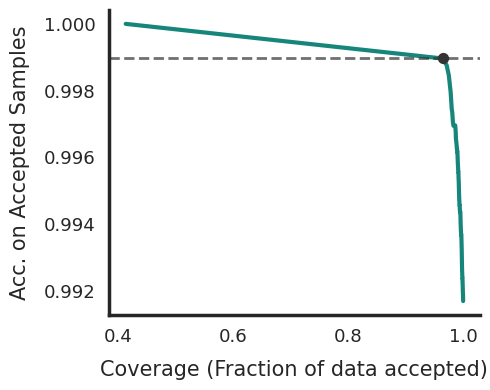

The model is stable up to 96.4% coverage with 99.90% accuracy.


In [6]:
# Run the sweep
thresholds, accuracies, coverages = calculate_idk_metrics(correct_scores, incorrect_scores)
final_acc, final_cov =  plot_bonus_tsk_acc_coverage_curve(coverages, accuracies)
print(f"The model is stable up to {final_cov:.1%} coverage with {final_acc:.2%} accuracy.")

In [7]:
TARGET_ACC = 0.9985
best_t = find_optimal_threshold(thresholds, accuracies, target_accuracy=TARGET_ACC)
print(f"Policy: Threshold set at {best_t:.4f} to achieve {TARGET_ACC*100}% accuracy.")

Policy: Threshold set at 0.9818 to achieve 99.85000000000001% accuracy.


In [8]:
# How many errors would we have caught?
errors_caught = sum(1 for c in incorrect_scores if c < best_t)
total_errors = len(incorrect_scores)

# How many correct predictions would we "waste" by calling them IDK?
correct_rejected = sum(1 for c in correct_scores if c < best_t)
total_correct = len(correct_scores)

print(f"At threshold {best_t}:")
print(f"- Avoided {errors_caught}/{total_errors} errors ({errors_caught/total_errors:.1%})")
print(f"- Sacrificed {correct_rejected}/{total_correct} correct samples ({correct_rejected/total_correct:.1%})")

At threshold 0.9818181818181817:
- Avoided 71/83 errors (85.5%)
- Sacrificed 216/9917 correct samples (2.2%)


### Part 2

In [99]:
def predict_with_idk(model, loader, device, threshold=0.9):
    model.eval()
    results = []
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            output = model(data)
            
            # Convert logits to probabilities
            probs = F.softmax(output, dim=1)
            
            # Get max probability and its index
            max_probs, preds = torch.max(probs, dim=1)
            
            for i in range(len(preds)):
                conf = max_probs[i].item()
                label = preds[i].item()
                
                # Apply IDK Logic
                final_label = label if conf >= threshold else "IDK"
                
                results.append({
                    "prediction": final_label,
                    "confidence": conf,
                    "ground_truth": target[i].item()
                })
    return results

In [101]:
import fiftyone as fo
import fiftyone.zoo as foz

# Clean up existing datasets to avoid slug/name conflict
fiftyone_dataset_name = "mnist_idk_experiment"
if fiftyone_dataset_name in fo.list_datasets():
    fo.delete_dataset(fiftyone_dataset_name)

# Load MNIST from the Zoo: this automatically handles the binary files and creates the PNGs FiftyOne needs
dataset = foz.load_zoo_dataset(
    "mnist",
    split="test",
    dataset_name=fiftyone_dataset_name,
)

# Generate predictions using existing model using threshold we selected (0.9818)
IDK_THRESHOLD = 0.9818
results = predict_with_idk(model, test_loader, DEVICE, threshold=IDK_THRESHOLD)

# Add the predictions to the FiftyOne dataset
# The Zoo MNIST and Torchvision MNIST 'test' splits are ordered identically
samples = dataset.sort_by("filepath")

print("Applying IDK predictions to FiftyOne...")
for sample, res in zip(samples, results):
    label = str(res["prediction"])
    
    # Add the classification
    sample["idk_model"] = fo.Classification(
        label=label,
        confidence=res["confidence"]
    )
    
    # Add a boolean field for easy filtering in the UI
    sample["is_idk"] = (label == "IDK")
    
    # Compare with ground truth to see if the model was right to say IDK
    # (Optional, but helpful for your report)
    sample.save()

# Launch the App
session = fo.launch_app(dataset)

Split 'test' already downloaded
Loading 'mnist' split 'test'
 100% |█████████████| 10000/10000 [4.4s elapsed, 0s remaining, 2.3K samples/s]      
Dataset 'mnist_idk_experiment' created
Applying IDK predictions to FiftyOne...


In [102]:
# Define the export path and a metadata.jsonl file so the scores show up in the table
export_dir = os.path.join(ROOT_DATA, "mnist_idk_evaluation_export")

# Perform the export
# This creates a folder containing:
# - data/ (the images)
# - samples.json (all metrics: clip_score, uniqueness, representativeness, embeddings)
# - metadata.json (dataset info)
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True
)

print(f"FiftyOne dataset exported to {export_dir}")

Exporting samples...
 100% |████████████████| 10000/10000 [1.9s elapsed, 0s remaining, 6.7K docs/s]        
FiftyOne dataset exported to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/data/mnist_idk_evaluation_export
